# Binary Classification for Brain MRI

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Import Packages

In [ ]:
# !pip install tensorflow_io

In [ ]:
import cv2
import shutil
import pickle
import datetime
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow_io as tfio
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras import backend as K
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input, Conv2D, Activation, SeparableConv2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm_notebook

In [ ]:
print(tf.__version__)

2.3.0


## Check for Binary Classification

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/brain_mri/images_masks_diagnosis.csv')
df.head()

,images,masks,diagnosis
0,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
1,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
2,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
3,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0
4,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19...,0


In [ ]:
sample = df[df['diagnosis'] == 0].sample(4).values
for datapoint in sample:
  mask_path = datapoint[1]
  min_pixel_value = np.min(cv2.imread(mask_path))
  max_pixel_value = np.max(cv2.imread(mask_path))
  print('mask_path: ', mask_path)
  print('Minimum pixel value: ', min_pixel_value)
  print('Maximum pixel value: ', max_pixel_value)
  print('*'*20)

mask_path:  lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_2_mask.tif
Minimum pixel value:  0
Maximum pixel value:  0
********************
mask_path:  lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_2_mask.tif
Minimum pixel value:  0
Maximum pixel value:  0
********************
mask_path:  lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_18_mask.tif
Minimum pixel value:  0
Maximum pixel value:  0
********************
mask_path:  lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif
Minimum pixel value:  0
Maximum pixel value:  0
********************


**OBSERVATION:**

* Here we can conclude that since the the pixel values of all the masks with negative values have been observed to be zero (0), hence we can pose this problem initially as binary classification based to segregate the positive and negative images and later perform segmentation on the positive ones

## Data Preprocessing

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['diagnosis'], random_state=42)
print('train_df: ', train_df.shape)
print('test_df: ', test_df.shape)

train_df:  (3143, 3)
test_df:  (786, 3)


In [ ]:
def plot_hist(df, text):

  '''Function to generate the countplot of target-labels'''

  plt.figure(figsize=(10,10))
  plt.subplot(2,2,2)
  plt.title(text)  
  sns.countplot(x='diagnosis', data=df)
  plt.show();

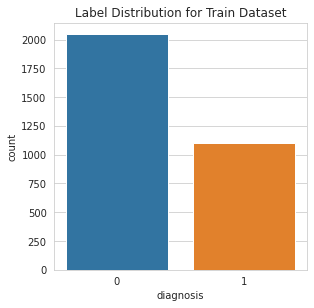

In [ ]:
plot_hist(train_df, 'Label Distribution for Train Dataset')

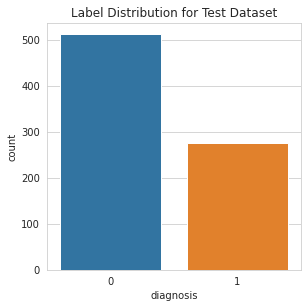

In [ ]:
plot_hist(test_df, 'Label Distribution for Test Dataset')

In [ ]:
train_images = np.asarray(train_df['images'])
train_diagnosis = np.asarray(train_df['diagnosis'])
test_images = np.asarray(test_df['images'])
test_diagnosis = np.asarray(test_df['diagnosis'])
print('train_images', len(train_images))
print('train_diagnosis', len(train_diagnosis))
print('test_images', len(test_images))
print('test_diagnosis', len(test_diagnosis))

train_images 3143
train_diagnosis 3143
test_images 786
test_diagnosis 786


In [ ]:
def parse_data(image_path, label):

  '''Function to perform image-preprocessing'''

  image = tf.io.read_file(image_path) #reads the image from the file path  
  image = tfio.experimental.image.decode_tiff(image)  #decodes the tiff file   
  image = tf.image.convert_image_dtype(image, tf.float32) #converts the float values in [0 1] interval
  image = tf.image.resize(image, [256, 256]) # resizes the image
  return image, label

In [ ]:
def augment_data(image, label):

  '''Function to perform data-augmentation'''

  a = np.random.uniform()
  if a<0.33:    
    image = tf.image.random_flip_left_right(image)    
  elif a<0.66:    
    image = tf.image.random_flip_up_down(image)
  else:    
    image = tf.image.random_brightness(image, max_delta=32.0/255.0)
    
  image = tf.clip_by_value(image, 0.0, 1.0) #ensures the float values to be in [0 1] interval
  return image, label

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(train_images), tf.constant(train_diagnosis)))
train_dataset = train_dataset.map(parse_data)
train_dataset = train_dataset.map(augment_data)
train_dataset = train_dataset.shuffle(len(train_images))
train_dataset = train_dataset.batch(16)

In [ ]:
sample_train_input, sample_train_target = next(iter(train_dataset))
print('sample_train_input: ', sample_train_input.shape)
print('sample_train_target: ', sample_train_target.shape)

sample_train_input:  (16, 256, 256, 4)
sample_train_target:  (16,)


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.constant(test_images), tf.constant(test_diagnosis)))
test_dataset = test_dataset.map(parse_data)
test_dataset = test_dataset.batch(16)

In [ ]:
sample_test_input, sample_test_target = next(iter(test_dataset))
print('sample_test_input: ', sample_test_input.shape)
print('sample_test_target: ', sample_test_target.shape)

sample_test_input:  (16, 256, 256, 4)
sample_test_target:  (16,)


## Model Building & Training

In [ ]:
# https://github.com/sandgate-dev/coding-practice/blob/master/coding/ml-dl/tensorfow/ch3-xception/implementation-of-xception-model.md

def conv_block(x, filters, block_num, conv_num, strides=(1,1)):
    name = 'block{}_conv{}_'.format(block_num, conv_num)

    # conv-BN-relu
    x = Conv2D(filters, (3,3), strides=(2,2), use_bias=False, name=name)(x)
    x = BatchNormalization(name=name+'bn')(x)
    x = Activation('relu', name=name+'act')(x)

    return x

def separable_conv_block(x, filters, block_num, conv_num, pre_activation=None):
    name = 'block{}_sepconv{}_'.format(block_num, conv_num)

    if pre_activation is True:
        x = Activation('relu', name=name+'act')(x)

    # (relu)-sepconv-BN-(relu)
    x = SeparableConv2D(filters, (3,3), padding='same', use_bias=False, name=name)(x)
    x = BatchNormalization(name=name+'bn')(x)

    if pre_activation is False:
        x = Activation('relu', name=name+'act')(x)

    return x

def middle_flow_block(x, filters, block_num):    
    # middle flow
    residual = x

    x = separable_conv_block(x, filters, block_num=block_num, conv_num='1', pre_activation=True)
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='2', pre_activation=True)
    x = separable_conv_block(x, filters, block_num=block_num, conv_num='3', pre_activation=True)

    return layers.add([x, residual])

def xception_block(x, filters, block_num, pre_activation=True):
    block = 'block{}_'.format(block_num)
    filter_conv1, filter_conv2 = filters

    # residual conv branch
    residual = Conv2D(filter_conv2, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    # separable conv block
    x = separable_conv_block(x, filter_conv1, block_num=block_num, conv_num='1', pre_activation=pre_activation)
    x = separable_conv_block(x, filter_conv2, block_num=block_num, conv_num='2', pre_activation=True)

    # downsampling and merging
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name=block+'pool')(x)

    return layers.add([x, residual])

def Modified_Xception(input_shape=(256,256,4), classes=1):
    """Instantiates the Xception architecture.
    """

    img_input = Input(shape=input_shape)

    #===========ENTRY FLOW==============
    #Block 1
    x = conv_block(img_input, 32, block_num='1', conv_num='1', strides=(2,2))
    x = conv_block(x, 64, block_num='1', conv_num='2')

    #Block 2
    x = xception_block(x, (128, 128), '2', pre_activation=False)

    #Block 3
    x = xception_block(x, (256, 256), '3')

    #Block 4
    x = xception_block(x, (728, 728), '4')


    #===========MIDDLE FLOW===============
    for i in range(8):
        block_num = str(5+i)
        x = middle_flow_block(x, 728, block_num)

    #========EXIT FLOW============
    #Block 13
    x = xception_block(x, (728, 1024), '13') # second conv is different

    # Block 14
    x = separable_conv_block(x, 1536, block_num='14', conv_num='1', pre_activation=False)
    x = separable_conv_block(x, 2048, block_num='14', conv_num='2', pre_activation=False)

    # logistic regression
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)    

    # custom layers
    x = Dense(1024, activation='relu', kernel_initializer='he_normal', name='dense_layer_1')(x)
    x = BatchNormalization(name='bn_layer_1')(x)
    x = Dropout(0.8, name='dropout_layer_1')(x)

    x = Dense(512, activation='relu', kernel_initializer='he_normal', name='dense_layer_2')(x)
    x = BatchNormalization(name='bn_layer_2')(x)
    x = Dropout(0.8, name='dropout_layer_2')(x)

    x = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense_layer_3')(x)
    x = Dense(1, activation='sigmoid', name='predictions')(x)

    # Create model.
    model = Model(inputs=img_input, outputs=x, name='modified_xception')
    return model

In [ ]:
model = Modified_Xception()
model.summary()

Model: "modified_xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
block1_conv1_ (Conv2D)          (None, 127, 127, 32) 1152        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1_[0][0]              
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________

**NOTE:**
  
  *   **RECALL:** Out of all the actual positive points, the recall function will determine what percentage of them are predicted to be positive by the model
  *   **PRECISION:** Out of all the points the model predicted to be positive, the precision function will determine what percentage of them are actually positive
  *   **F1-SCORE:** Since we want both the recall and the precision to be high, so we shall monitor the F1-Score too which should also be high

In [ ]:
# https://stackoverflow.com/questions/59196793/why-are-my-metrics-of-my-cnn-not-changing-with-each-epoch

def recall_m(y_true, y_pred):
    '''
    This function returns recall_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns recall score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # calculates number of true positives
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      # calculates number of actual positives
    recall = true_positives / (possible_positives + K.epsilon())   # K.epsilon takes care of non-zero divisions
    return recall

def precision_m(y_true, y_pred):
    '''
    This function returns precison_score between y_true and y_pred
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns prediction score of the batch
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))  # calculates number of true positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))      # calculates number of predicted positives   
    precision = true_positives /(predicted_positives + K.epsilon()) # K.epsilon takes care of non-zero divisions
    return precision

def f1_score_m(y_true, y_pred):
    '''
    This function returns f1_score between y_true and y_pred
    This 
    This function is ported as a metric to the Neural Network Models
    Keras backend is used to take care of batch type training, the metric takes in a batch of y_pred and corresponding y_pred 
    as input and returns f1 score of the batch
    '''
    precision = precision_m(y_true, y_pred)  # calls precision metric and takes the score of precision of the batch
    recall = recall_m(y_true, y_pred)        # calls recall metric and takes the score of precision of the batch
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
filepath = "/content/gdrive/My Drive/brain_mri/xception_model_epochs:{epoch:03d}-val_accuracy:{val_accuracy:.3f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor="val_accuracy", save_best_only=True, verbose=1)

In [ ]:
log_dir = "/content/gdrive/My Drive/brain_mri/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, profile_batch=0)

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)

In [ ]:
callback_list = [checkpoint, tensorboard, early_stopping]

In [ ]:
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy', recall_m, precision_m, f1_score_m])
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset, epochs=100, validation_data=test_dataset, callbacks=callback_list)

Epoch 1/100
197/197 [==============================] - ETA: 0s - loss: 1.0101 - accuracy: 0.6087 - recall_m: 0.3103 - precision_m: 0.4423 - f1_score_m: 0.3358
Epoch 00001: val_accuracy improved from -inf to 0.65013, saving model to /content/gdrive/My Drive/brain_mri/xception_model_epochs:001-val_accuracy:0.650.h5
197/197 [==============================] - 31s 157ms/step - loss: 1.0101 - accuracy: 0.6087 - recall_m: 0.3103 - precision_m: 0.4423 - f1_score_m: 0.3358 - val_loss: 0.6843 - val_accuracy: 0.6501 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_score_m: 0.0000e+00
Epoch 2/100
197/197 [==============================] - ETA: 0s - loss: 0.8052 - accuracy: 0.6608 - recall_m: 0.4724 - precision_m: 0.5247 - f1_score_m: 0.4682
Epoch 00002: val_accuracy did not improve from 0.65013
197/197 [==============================] - 26s 130ms/step - loss: 0.8052 - accuracy: 0.6608 - recall_m: 0.4724 - precision_m: 0.5247 - f1_score_m: 0.4682 - val_loss: 0.6662 - val_accuracy: 

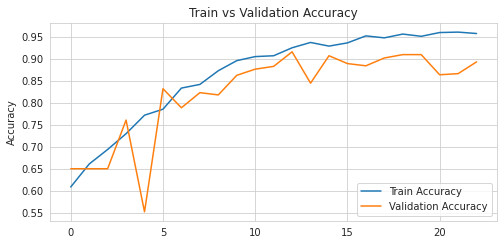

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.show()

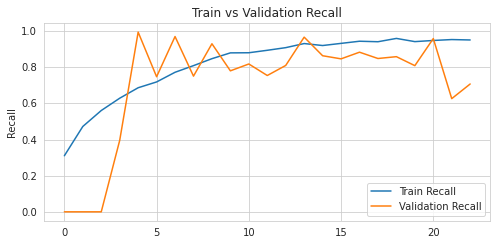

In [ ]:
recall_m = history.history['recall_m']
val_recall_m = history.history['val_recall_m']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(recall_m, label='Train Recall')
plt.plot(val_recall_m, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.title('Train vs Validation Recall')
plt.show()

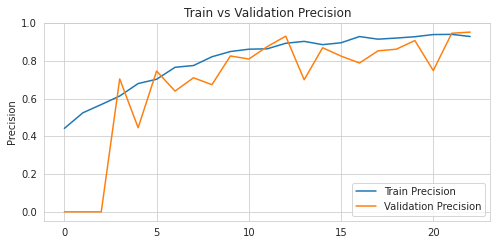

In [ ]:
precision_m = history.history['precision_m']
val_precision_m = history.history['val_precision_m']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(precision_m, label='Train Precision')
plt.plot(val_precision_m, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.title('Train vs Validation Precision')
plt.show()

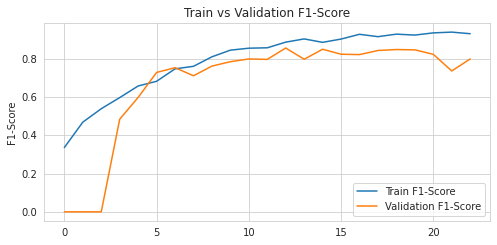

In [ ]:
f1_score_m = history.history['f1_score_m']
val_f1_score_m = history.history['val_f1_score_m']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(f1_score_m, label='Train F1-Score')
plt.plot(val_f1_score_m, label='Validation F1-Score')
plt.legend(loc='lower right')
plt.ylabel('F1-Score')
plt.title('Train vs Validation F1-Score')
plt.show()

**OBSERVATION**

*   Here we observe that considering all the thresholds, the best scores we observe is at epoch 13 where the accuracy and val_accuracy are 0.9252 and 0.9160 respectively
*   Hence, we can conclude that the model is not overfitting and consider this to be the best-model with recall and precision values to be 81% and 93% respetively. 
*   Furthermore, the F1-Score is also observed to be 86%

In [ ]:
dependencies = {
    'recall_m':recall_m,
    'precision_m':precision_m,    
    'f1_score_m':f1_score_m    
}

In [ ]:
best_model = load_model('/content/gdrive/My Drive/brain_mri/xception_model_epochs:013-val_accuracy:0.916.h5', custom_objects=dependencies)

In [ ]:
y_pred_prob = best_model.predict(test_dataset, batch_size=16)

In [ ]:
y_pred = []
for element in y_pred_prob:
  if element < 0.5:
    y_pred.append(0)
  else:
    y_pred.append(1)

In [ ]:
conf_matrix = confusion_matrix(test_diagnosis, y_pred)

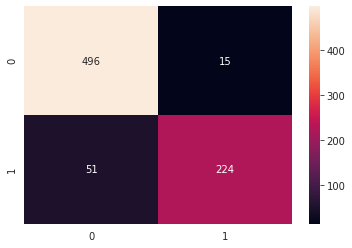

In [ ]:
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
labels = [f"{v1}" for v1 in group_counts]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='');